In [ ]:
%cd ..

In [2]:
import torch
import torch.nn as nn

from torchinfo import summary

from src.neuralnet.preprocess import prepare_data
from src.neuralnet.model import TabBERT
from src.neuralnet.train import train_model

In [3]:
TRANSFORMER_MODEL = 'prajjwal1/bert-tiny'  # 'bert-base-uncased'
MAX_LENGTH = 512
SEED = 42

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
train_loader, val_loader, columns_idx, embedding_sizes, n_continuous = prepare_data(
    TRANSFORMER_MODEL, MAX_LENGTH, device, SEED
)

In [5]:
# Set seeds for random modules
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

# Initialize the model
model = TabBERT(embedding_sizes, n_continuous, TRANSFORMER_MODEL, device).to(device)

# Set up optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)  # Fine-tuning BERT with a small learning rate
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()  # Binary Cross-Entropy for binary classification

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
inputs, labels = next(iter(train_loader))

input_example = {
    'input_ids': inputs[:1][:, columns_idx['INPUT_IDS_START']:columns_idx['INPUT_IDS_END']],
    'attention_mask': inputs[:1][:, columns_idx['ATTENTION_MASK_START']:columns_idx['ATTENTION_MASK_END']],
    'x_cat': inputs[:1][:, columns_idx['CATEGORICAL_START']:columns_idx['CATEGORICAL_END']],
    'x_cont': inputs[:1][:, columns_idx['NUMERIC_START']:columns_idx['NUMERIC_END']]
}

pred_probab = model(**input_example)
print('probabilities:', pred_probab)

probabilities: tensor([0.4960], device='cuda:0', grad_fn=<SelectBackward0>)


In [7]:
summary(model, input_data=input_example)

Layer (type:depth-idx)                                            Output Shape              Param #
TabBERT                                                           [1]                       --
├─BertForSequenceClassification: 1-1                              [1, 2]                    --
│    └─BertModel: 2-1                                             [1, 128]                  --
│    │    └─BertEmbeddings: 3-1                                   [1, 512, 128]             3,972,864
│    │    └─BertEncoder: 3-2                                      [1, 512, 128]             396,544
│    │    └─BertPooler: 3-3                                       [1, 128]                  16,512
│    └─Dropout: 2-2                                               [1, 128]                  --
│    └─Linear: 2-3                                                [1, 2]                    258
├─Softmax: 1-2                                                    [1, 2]                    --
Total params: 4,386,178
Trai

In [8]:
# input_names = ["Review Data"]
# output_names = ["Sentiment Prediction"]

# torch.onnx.export(model, input_example, "data/model.onnx", input_names=input_names, output_names=output_names)

Epoch [1/25], Loss: 0.6758, Val Loss: 0.6462, Val ROC-AUC: 0.6407
Epoch [2/25], Loss: 0.6289, Val Loss: 0.6080, Val ROC-AUC: 0.6576
Epoch [3/25], Loss: 0.5998, Val Loss: 0.5813, Val ROC-AUC: 0.6542
Epoch [4/25], Loss: 0.5799, Val Loss: 0.5615, Val ROC-AUC: 0.6610
Epoch [5/25], Loss: 0.5646, Val Loss: 0.5488, Val ROC-AUC: 0.6721
Epoch [6/25], Loss: 0.5547, Val Loss: 0.5404, Val ROC-AUC: 0.6876
Epoch [7/25], Loss: 0.5475, Val Loss: 0.5341, Val ROC-AUC: 0.7055
Epoch [8/25], Loss: 0.5420, Val Loss: 0.5286, Val ROC-AUC: 0.7221
Epoch [9/25], Loss: 0.5369, Val Loss: 0.5235, Val ROC-AUC: 0.7399
Epoch [10/25], Loss: 0.5323, Val Loss: 0.5180, Val ROC-AUC: 0.7610
Epoch [11/25], Loss: 0.5276, Val Loss: 0.5113, Val ROC-AUC: 0.7817
Epoch [12/25], Loss: 0.5217, Val Loss: 0.5027, Val ROC-AUC: 0.8006
Epoch [13/25], Loss: 0.5138, Val Loss: 0.4926, Val ROC-AUC: 0.8157
Epoch [14/25], Loss: 0.5049, Val Loss: 0.4828, Val ROC-AUC: 0.8284
Epoch [15/25], Loss: 0.4969, Val Loss: 0.4734, Val ROC-AUC: 0.8395
Epoc

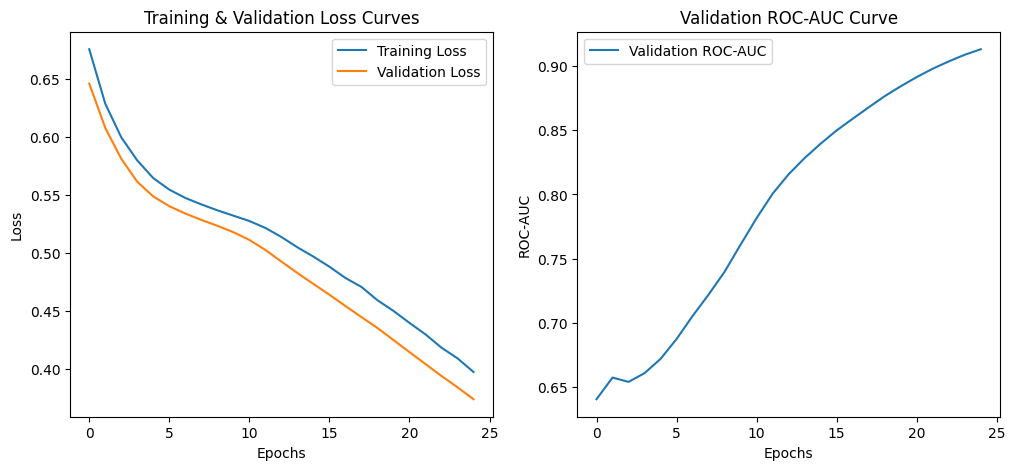

In [9]:
# Set seeds for random modules
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

# Train the model
train_model(model, train_loader, val_loader, columns_idx, criterion, optimizer, epochs=25)

In [10]:
torch.save(model.state_dict(), "data/model.pth")

In [11]:
# adamw 1e-5
# Epoch [9600/10000], Loss: 0.5379, Val Loss: 0.5312, Val ROC-AUC: 0.5443
# Epoch [10000/10000], Loss: 0.5367, Val Loss: 0.5313, Val ROC-AUC: 0.5442